In [1]:
!pip install pytorch_lightning
!pip install pymysql

from google.colab import drive
import sys

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 60.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [2]:
import re
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Optional

import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

from timeseries.utils import list2dict
from timeseries.transformer.eval import parse_informerPL_output
from timeseries.dataset import InformerDataset
from timeseries.transformer.models import InformerPL

def seed_everything(seed: int = 123):
    os.environ["PYTHONHASHSEED"] = str(seed)

    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # 이 설정을 켜 놓으면 성능 향상에 도움이 된다고 한다. 그러나 연산 후 값이 달라질 수 있는 것이다. https://tempdev.tistory.com/28

meat_type = 'pork'
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/livestock_price_data.xlsx", sheet_name='돼지_도매가격')

forecast_horizon = 30
seq_length = forecast_horizon * 2
label_length = int(forecast_horizon * 1.5)

df = df.iloc[4:, :2]
df.columns = ['date', 'price']

In [3]:
def extract_trend(x):
    if re.search('▼', x):
        symbol = -1
    elif re.search('▲', x):
        symbol = 1
    else:
        return np.nan

    x = re.split('▼|▲', x)[1]
    x= re.sub(',|-| ', '', x)

    return float(x) * symbol

df['price'] = df['price'].apply(lambda x: re.split('▼|▲', x)[0] if re.search('▼|▲', x) else x)
df['price'] = df['price'].apply(lambda x: re.sub(',|-| ', '', x))
df['price'] = df['price'].apply(lambda x: float(x) if x != '' else np.nan)

df = df.sort_values('date')
df = df[['date', 'price']]
df.index = range(len(df))

<Axes: title={'center': 'pork price'}, xlabel='date'>

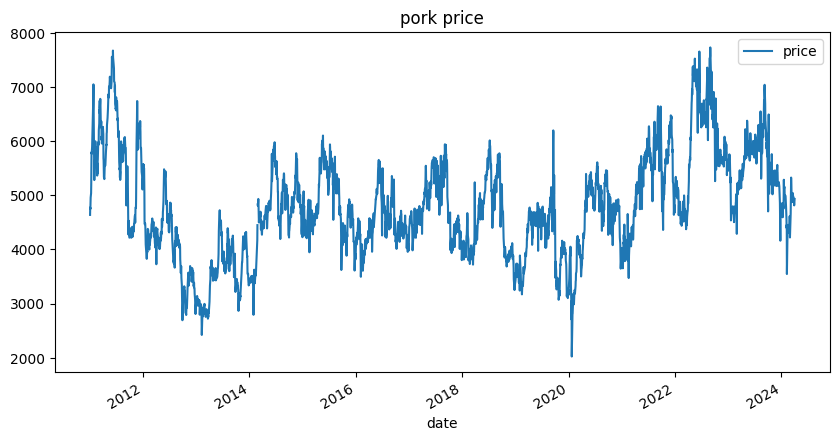

In [4]:
df.plot(x='date', y='price', title=f'{meat_type} price', figsize=(10, 5))

In [ ]:
def create_time_embedding(df: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    feature_funcs = {
        'day_of_week': lambda row: row.weekday() / 4 - 0.5,
        'day_of_month': lambda row: (row.day - 1) / 30 - 0.5,
        'month_of_year': lambda row: (row.month - 1) / 11 - 0.5,
        'day_of_year': lambda row: (row.dayofyear - 1) / 365 - 0.5,
        'quarter': lambda row: row.quarter / 4 - 0.5,
    }

    for feature in features:
        if feature in feature_funcs:
            df[feature] = df["date"].apply(feature_funcs[feature])

    return df

df['date'] = pd.to_datetime(df['date'])
input_vars = ['price']
target_var = 'price'
time_vars = ['day_of_week', 'day_of_month', 'month_of_year', 'day_of_year']
column_idxes = list2dict(input_vars)

data = create_time_embedding(df.copy(), time_vars)

In [ ]:
data

,date,price,day_of_week,day_of_month,month_of_year,day_of_year
0,2011-01-04,4776.0,-0.25,-0.400000,-0.500000,-0.491781
1,2011-01-05,4749.0,0.00,-0.366667,-0.500000,-0.489041
2,2011-01-06,4884.0,0.25,-0.333333,-0.500000,-0.486301
3,2011-01-07,4960.0,0.50,-0.300000,-0.500000,-0.483562
4,2011-01-10,5040.0,-0.50,-0.200000,-0.500000,-0.475342
...,...,...,...,...,...,...
3275,2024-03-26,4892.0,-0.25,0.333333,-0.318182,-0.267123
3276,2024-03-27,4871.0,0.00,0.366667,-0.318182,-0.264384
3277,2024-03-28,4868.0,0.25,0.400000,-0.318182,-0.261644
3278,2024-03-29,4815.0,0.50,0.433333,-0.318182,-0.258904


In [ ]:
train_size = int(data.shape[0] * 0.8)
test_size = data.shape[0] - train_size

print(f"train_size: {train_size}, test_size: {test_size}")

train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

train_size: 2624, test_size: 656


In [ ]:
sc = MinMaxScaler()

train_data[input_vars] = sc.fit_transform(train_data[input_vars])
test_data[input_vars] = sc.transform(test_data[input_vars])

In [ ]:
train_dataset = InformerDataset(
    train_data,
    seq_len=seq_length,
    label_len=label_length,
    pred_len=forecast_horizon,
    input_vars=input_vars,
    time_vars=time_vars
)

test_dataset = InformerDataset(
    test_data,
    seq_len=seq_length,
    label_len=label_length,
    pred_len=forecast_horizon,
    input_vars=input_vars,
    time_vars=time_vars
)

batch_size = 128
max_epochs = 1000

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
trainer = Trainer(max_epochs=max_epochs)

model_args = {
    "d_feature": len(input_vars), "d_mark": len(time_vars), "pred_len": forecast_horizon,"label_len": label_length,
    "target": target_var, "column_idxs": column_idxes,
    "d_k": 32, "d_v": 32, "n_heads": 4, "d_model": 128, "d_ff": 128,
    "e_layer": 1, "d_layer": 1, "dropout": 0.1, "lr": 0.001, "weight_decay": 0.001
}

model = InformerPL(**model_args)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params
---------------------------------------
0 | encoder    | Encoder | 299 K 
1 | decoder    | Decoder | 166 K 
2 | projection | Linear  | 129   
---------------------------------------
465 K     Trainable params
0         Non-trainable params
465 K     Total params
1.862     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
train_results = trainer.predict(model, dataloaders=train_dataloader)
test_results = trainer.predict(model, dataloaders=test_dataloader)

train_preds, train_trues = parse_informerPL_output(train_results, forecast_horizon, parse_method='sequence') # 20240304 yifan
test_preds, test_trues = parse_informerPL_output(test_results, forecast_horizon, parse_method='sequence') # 20240304 yifan

train_preds = sc.inverse_transform(train_preds)[:, column_idxes[target_var]]
train_trues = sc.inverse_transform(train_trues)[:, column_idxes[target_var]]

test_preds = sc.inverse_transform(test_preds)[:, column_idxes[target_var]]
test_trues = sc.inverse_transform(test_trues)[:, column_idxes[target_var]]

In [ ]:
train_results_df = pd.DataFrame({'preds': train_preds, 'trues': train_trues})
test_results_df = pd.DataFrame({'preds': test_preds, 'trues': test_trues})

results_df = pd.concat([train_results_df, test_results_df])
results_df.index = range(len(results_df))

In [ ]:
test_results_df.shape

In [ ]:
plt.figure(figsize=(15, 5))
plt.axvline(len(train_results_df), color='r', linestyle='--')
plt.plot(results_df['trues'], label='true')
plt.plot(results_df['preds'], label='pred')
plt.legend()
plt.show()

In [ ]:
print("학습데이터 성능평가:")
print('Train RMSE:', np.sqrt(mean_squared_error(train_trues, train_preds)))
print('Train MAPE:', mean_absolute_percentage_error(train_trues, train_preds))

print("\n\n테스트데이터 성능평가:")
print('Test RMSE:', np.sqrt(mean_squared_error(test_trues, test_preds)))
print('Test MAPE:', mean_absolute_percentage_error(test_trues, test_preds))